In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
# Загрузка данных из Excel-файла и первичный анализ
target_xlsx ='https://lms.skillfactory.ru/asset-v1:SkillFactory+MIFIML-2sem+2025+type@asset+block@%D0%94%D0%B0%D0%BD%D0%BD%D1%8B%D0%B5_%D0%B4%D0%BB%D1%8F_%D0%BA%D1%83%D1%80%D1%81%D0%BE%D0%B2%D0%BE%D0%B8__%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%9C%D0%9E.xlsx'
df = pd.read_excel(target_xlsx)

In [40]:
display(df.head())

,Unnamed: 0,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,...,0,0,0,0,0,0,0,0,3,0
1,1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,...,0,0,0,0,0,0,0,0,3,0
2,2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,...,0,0,0,0,0,0,0,0,3,0
3,3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,...,0,0,0,0,0,0,0,0,4,0
4,4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,...,0,0,0,0,0,0,0,0,0,0


In [41]:
!pip install catboost xgboost scikit-learn matplotlib seaborn joblib pandas numpy

In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [43]:
RANDOM_STATE = 123

In [44]:
target = 'SI'
X = df.drop(['Unnamed: 0','IC50, mM', 'CC50, mM', 'SI'], axis=1) # Удаляем целевую и связанные переменные
y = df[target]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
model.fit(X_train, y_train)

feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

In [46]:
print("Топ-10 наиболее важных дескрипторов для IC50:")
feature_importances.head(10)

Топ-10 наиболее важных дескрипторов для IC50:


,0
VSA_EState6,0.399126
VSA_EState9,0.083731
FpDensityMorgan1,0.033675
MinPartialCharge,0.026929
BalabanJ,0.026566
Chi1,0.023823
MaxPartialCharge,0.021419
qed,0.017184
Chi1n,0.016737
Kappa3,0.016715


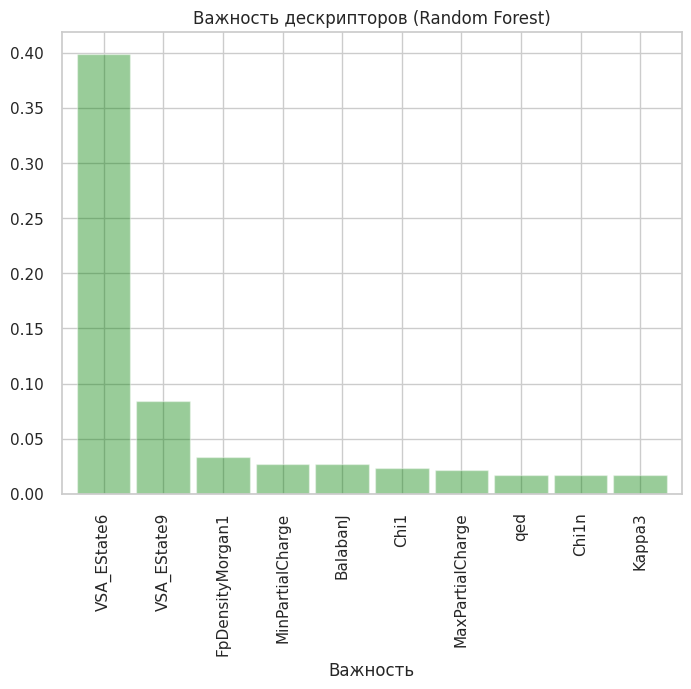

In [47]:
plt.figure(figsize=(8, 6))
feature_importances.head(10).plot(kind='bar', width=0.9, color='green', alpha=0.4)
plt.title('Важность дескрипторов (Random Forest)')
plt.xlabel('Важность')
plt.show()

In [48]:
plt.style.use('seaborn-v0_8')
sns.set_theme(style="whitegrid")
sns.set_palette("husl")

In [49]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer

In [50]:
# Исключаем ненужные столбцы
cols_to_exclude = ['IC50, mM', 'CC50, mM', 'SI']
X = df.drop(columns=[col for col in cols_to_exclude if col in df.columns], errors='ignore')
y = df[target]

df_regress = X.copy()

# Добавление новых признаков молярный
df_regress['MolLogP_MolWt'] = df_regress['MolLogP'] * df_regress['MolWt']

In [51]:
# Полиномиальные признаки
existing_poly_cols = [col for col in ['MolLogP', 'MolWt'] if col in df_regress.columns]

In [52]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df_regress[existing_poly_cols])
poly_feature_names = poly.get_feature_names_out(existing_poly_cols)

new_poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=df_regress.index)
for col in new_poly_df.columns:
   if col not in df_regress.columns:
       df_regress[col] = new_poly_df[col]

In [53]:
df_regress['MolLogP_gt_3'] = (df_regress['MolLogP'] > 3).astype(int)

In [54]:
imputer = SimpleImputer(strategy='median')
df_regress = pd.DataFrame(imputer.fit_transform(df_regress), columns=df_regress.columns)

In [55]:
print("Получили новые признаки:", [col for col in df_regress.columns if col not in df.columns])

Получили новые признаки: ['MolLogP_MolWt', 'MolLogP^2', 'MolLogP MolWt', 'MolWt^2', 'MolLogP_gt_3']


In [56]:
X_train, X_test, y_train, y_test = train_test_split(df_regress, y, test_size=0.2, random_state=RANDOM_STATE)

**KNN**

In [57]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [58]:
results = []
best_r2 = 0
best_model = ''

In [59]:
model = KNeighborsRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
res = {'Model':'KNN',  'MSE':mse,  'RMSE': rmse, 'MAE':mae, 'r2': r2}
results.append(res)


**Random Forest**

In [60]:
model = RandomForestRegressor(random_state=RANDOM_STATE)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
res = {'Model':'Random Forest',  'MSE':mse,  'RMSE': rmse, 'MAE':mae, 'r2': r2}
results.append(res)

**Gradient Boosting**

In [61]:
from sklearn.ensemble import GradientBoostingRegressor

In [62]:
model = GradientBoostingRegressor(random_state=RANDOM_STATE)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
res = {'Model':'Gradient Boosting',  'MSE':mse,  'RMSE': rmse, 'MAE':mae, 'r2': r2}
results.append(res)

**HistGradientBoosting**

In [63]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [64]:
model = HistGradientBoostingRegressor(random_state=RANDOM_STATE)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
res = {'Model':'HistGradientBoosting',  'MSE':mse,  'RMSE': rmse, 'MAE':mae, 'r2': r2}
results.append(res)

**AdaBoostRegressor**

In [65]:
from sklearn.ensemble import  AdaBoostRegressor

In [66]:
model = AdaBoostRegressor(random_state=RANDOM_STATE)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
res = {'Model':'AdaBoostRegressor',  'MSE':mse,  'RMSE': rmse, 'MAE':mae, 'r2': r2}
results.append(res)

**XGBoost**

In [67]:
from xgboost import XGBRegressor

In [68]:
model = XGBRegressor(random_state=RANDOM_STATE)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
res = {'Model':'XGBoost',  'MSE':mse,  'RMSE': rmse, 'MAE':mae, 'r2': r2}
results.append(res)

 **CatBoost**

In [69]:
from catboost import CatBoostRegressor

In [70]:
model = CatBoostRegressor(random_state=RANDOM_STATE, verbose=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
res = {'Model':'CatBoost',  'MSE':mse,  'RMSE': rmse, 'MAE':mae, 'r2': r2}
results.append(res)

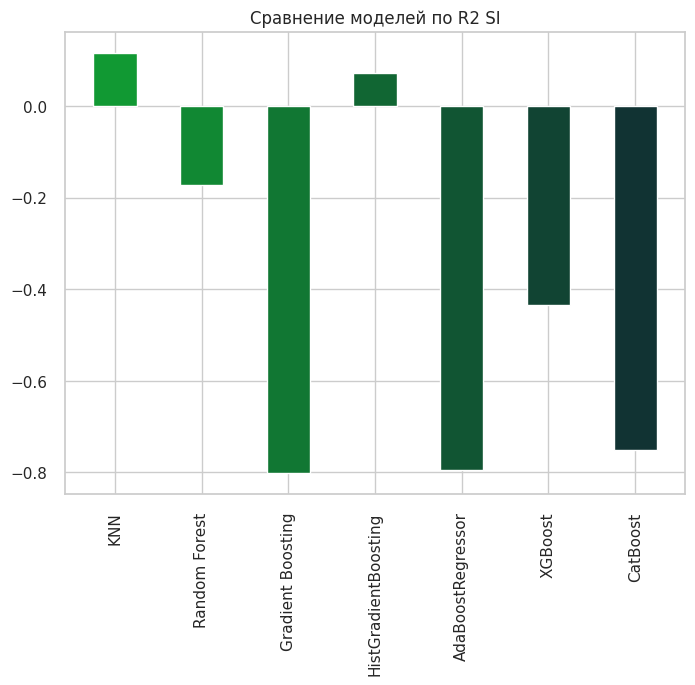

In [75]:
results_df = pd.DataFrame(results)

plt.figure(figsize=(8, 6))

plt.xticks(rotation=90)
colors =  [ '#193', '#183', '#173', '#163', '#153', '#143', '#133']
plt.title(f'Сравнение моделей по R2 {target}')
plt.bar(results_df['Model'], results_df['r2'], width=0.5, color=colors)
plt.show()

In [72]:
print(f"Результаты моделей (таргет: {target}):")

results_df

Результаты моделей (таргет: SI):


,Model,MSE,RMSE,MAE,r2
0,KNN,1.221340e+06,1105.142410,181.916912,0.116976
1,Random Forest,1.620292e+06,1272.906985,213.540525,-0.171466
2,Gradient Boosting,2.489946e+06,1577.956395,257.932775,-0.800223
3,HistGradientBoosting,1.284243e+06,1133.244456,189.409971,0.071497
4,AdaBoostRegressor,2.480675e+06,1575.016015,285.854219,-0.793520
5,XGBoost,1.984235e+06,1408.628915,202.759415,-0.434595
6,CatBoost,2.423124e+06,1556.638701,253.662441,-0.751910


In [73]:
print(f"Наилучший результат \n{results_df[results_df['r2']==results_df['r2'].max()]}")

Наилучший результат 
  Model           MSE        RMSE         MAE        r2
0   KNN  1.221340e+06  1105.14241  181.916912  0.116976
